In [2]:
#Installing relevent packages
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib
import glob
from primaite import PRIMAITE_PATHS
from pathlib import Path
import numpy as np


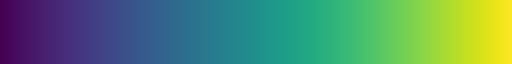

In [13]:
plt.get_cmap()

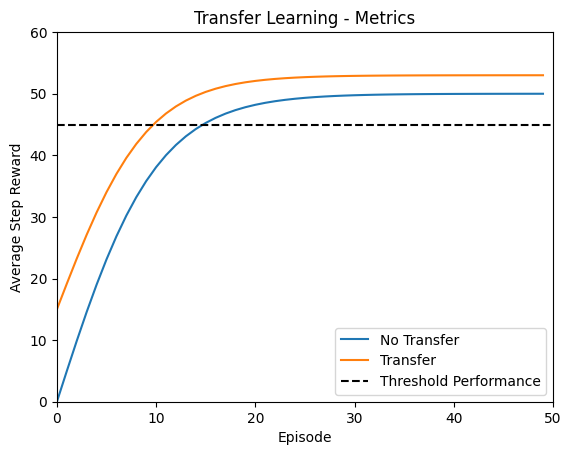

In [43]:
x = np.arange(0, 50)
y1 = 50*np.tanh(0.1*x)
y2 = 38*np.tanh(0.11*x)+15
plt.plot(x, y1, label = 'No Transfer')
plt.plot(x,y2, label = 'Transfer')
plt.axhline(y = 45, color = 'black', linestyle = '--', label = 'Threshold Performance') 

plt.xlim([0,50])
plt.ylim([0,60])
plt.title('Transfer Learning - Metrics')
plt.ylabel('Average Step Reward')
plt.xlabel('Episode')
plt.legend()
plt.show()

# Define helper functions
 Function to convert a list of csvs into a dataframe
 
 Function to find relevant csvs and plot them

In [3]:
def dataframe_constructor(csv_list, df_list, model):
    # Base case, if csv_list is empty then concatenate dataframes
    if len(csv_list) == 0:
        final_df = pd.concat(df_list, axis=1)
        final_df.index.name='Episode'
        final_df.index += 1
        return final_df
    # Recursive case, if csv_list is not empty then we have more csvs to convert to dataframes
    else:
       csv_to_to_append = csv_list.pop()
       df_to_append = pd.read_csv(csv_to_to_append, usecols=['Average Reward'])
       new_col_name = model + '_' + csv_to_to_append.name[27:-4]
       df_to_append.rename(columns={'Average Reward': new_col_name}, inplace=True)
       df_list.append(df_to_append)
       return dataframe_constructor(csv_list, df_list, model)
    
#We need to extract the files and store them
def generate_plot(subfolders_to_search,window,name):
    model_df_dict = {}
        
    # Find csvs and convert to dataframes
    for model in subfolders_to_search:
        model_ave_reward_files = []
        for time_stamp in subfolders_to_search[model]:
            time_stamp_files_path = Path.joinpath(PRIMAITE_PATHS.user_sessions_path.parent,'Hyperparameters',model,time_stamp)
            model_time_stamp_ave_reward_files = [filename for filename in time_stamp_files_path.glob('average*')]
            model_ave_reward_files += model_time_stamp_ave_reward_files
        model_df = dataframe_constructor(model_ave_reward_files, [], model)
        model_df_dict[f'{model}'] = model_df.rolling(window=window, center=False).mean()

        
    all_models_df = pd.concat(list(model_df_dict.values()), axis=1)

    if len(subfolders_to_search)==1:
        if name is None:
            title = model
        else:
            title = name
        columns = model_df_dict[model].columns.to_list()
        model_df_dict[model] = model_df_dict[model].rename(columns={col:col[len(model)+1:] for col in columns})
    else:
        title = None

    lineStyle = ['-','--',':','.-']
    ax = None
    cmap = plt.get_cmap()
    for iM, model in enumerate(model_df_dict.keys()):
        ax = model_df_dict[model].plot(ax=ax,
                lw=1, 
                figsize=(15,7),
                linestyle = lineStyle[iM],
                grid=True,
                cmap = cmap)
    ax.legend(loc='lower right')
    plt.xlabel('Episode', fontsize=16)
    plt.ylabel(f'Average Step Reward ({window} Episodes)', fontsize=15)
    plt.title(title, fontsize=17)
    plt.ticklabel_format(axis='y', style='sci', scilimits=(2,4))
    plt.savefig(f'{name}.png', bbox_inches='tight')
    plt.show()


### Action Space
Conclusions: It appears that the methodology works for large action spaces, and the DBM may actually outperform the NN for larger action spaces. Continue using 30 ACL rules.

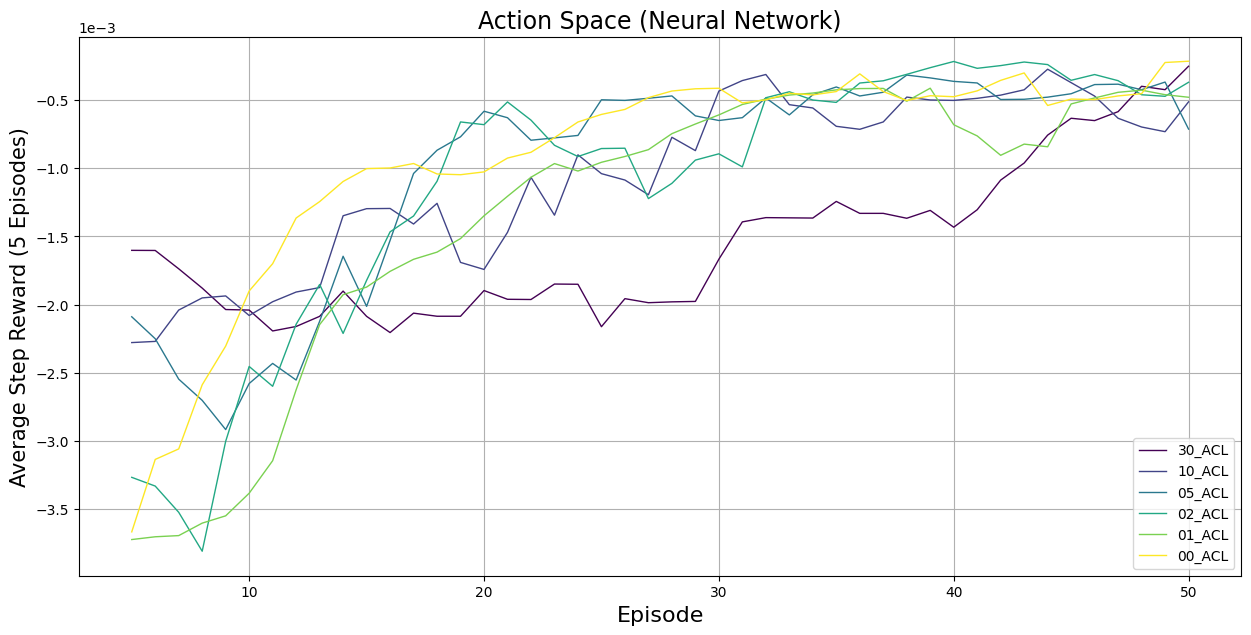

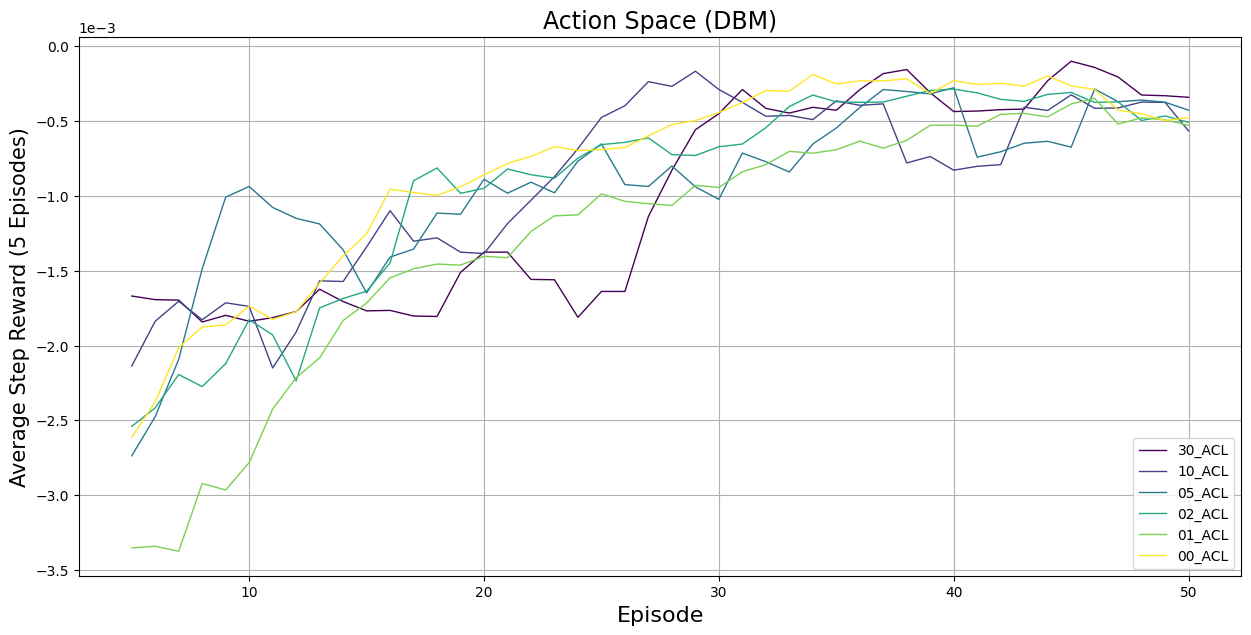

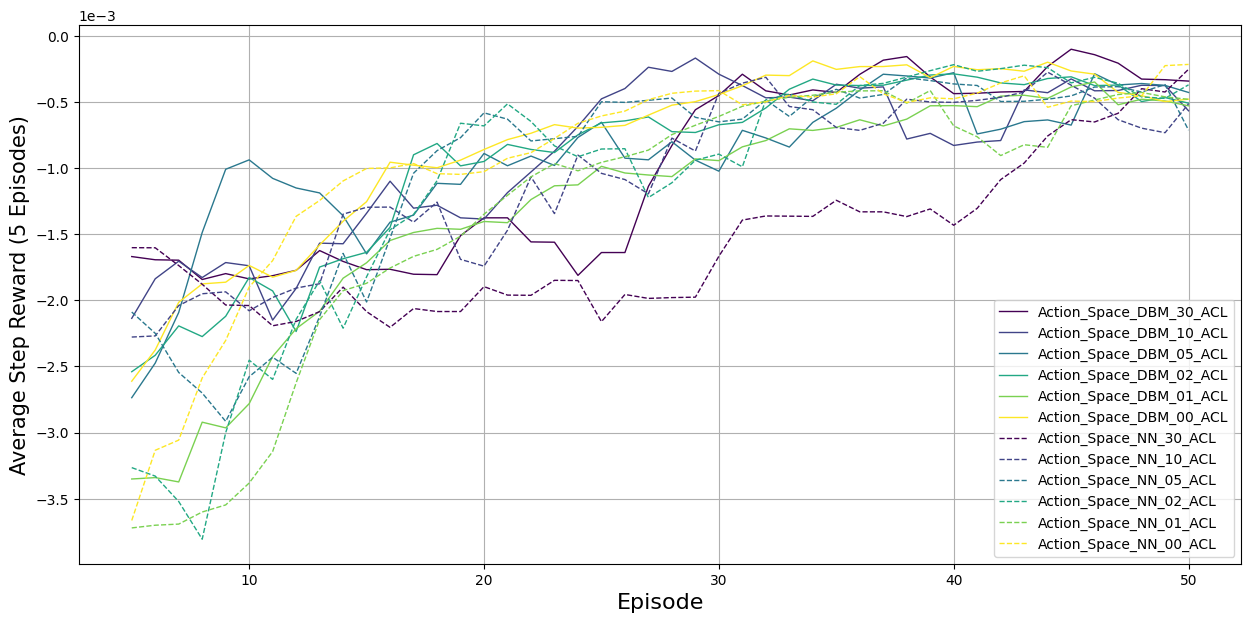

In [4]:

subfolders_to_search_NN: dict = {'Action_Space_NN': ['2023-11-13_17-44-15_renamed']}
name = 'Action Space (Neural Network)'
window = 5
generate_plot(subfolders_to_search_NN,window,name)

subfolders_to_search_DBM: dict = {'Action_Space_DBM': ['2023-11-09_10-54-24_renamed']}
name = 'Action Space (DBM)'
window = 5
generate_plot(subfolders_to_search_DBM,window,name)

subfolders_to_search = {**subfolders_to_search_DBM,**subfolders_to_search_NN}
name = 'Action Space'
window = 5
generate_plot(subfolders_to_search,window,name)


### Learning Rate
Conclusions: 3E-3 optimal for policy network. 3E-4 optimal for value network (3E-4 also acceptable for policy network). Continue with optimal parameters, and 3E-4 for the 'both network' case if it's not possible to consider different rates.

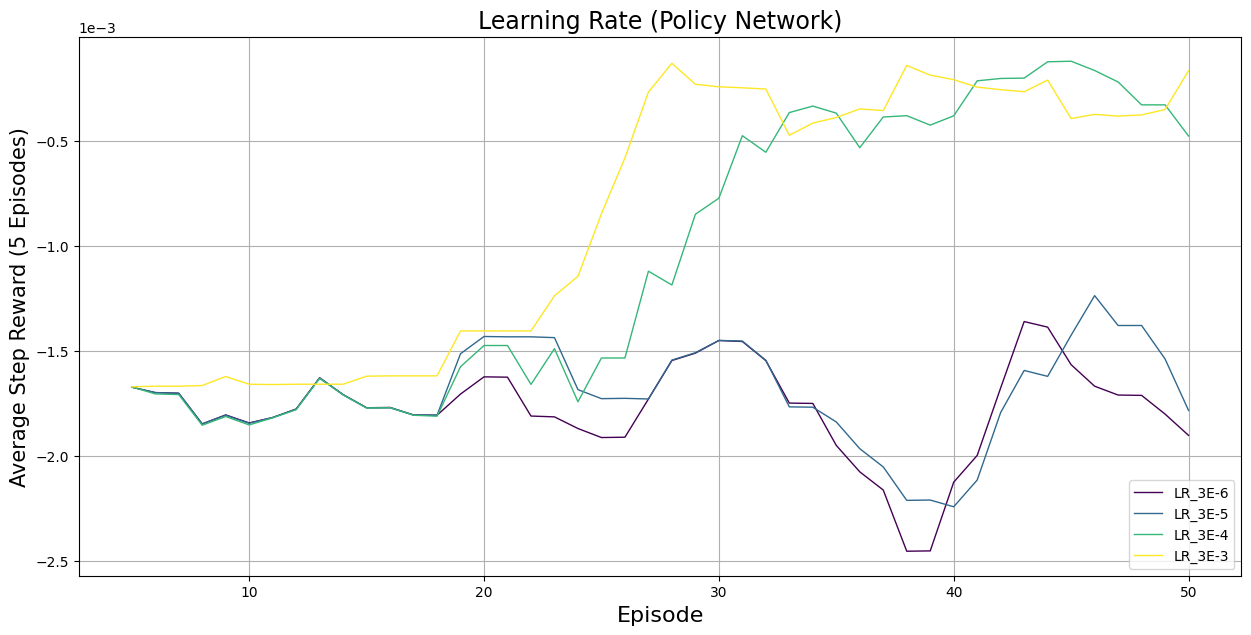

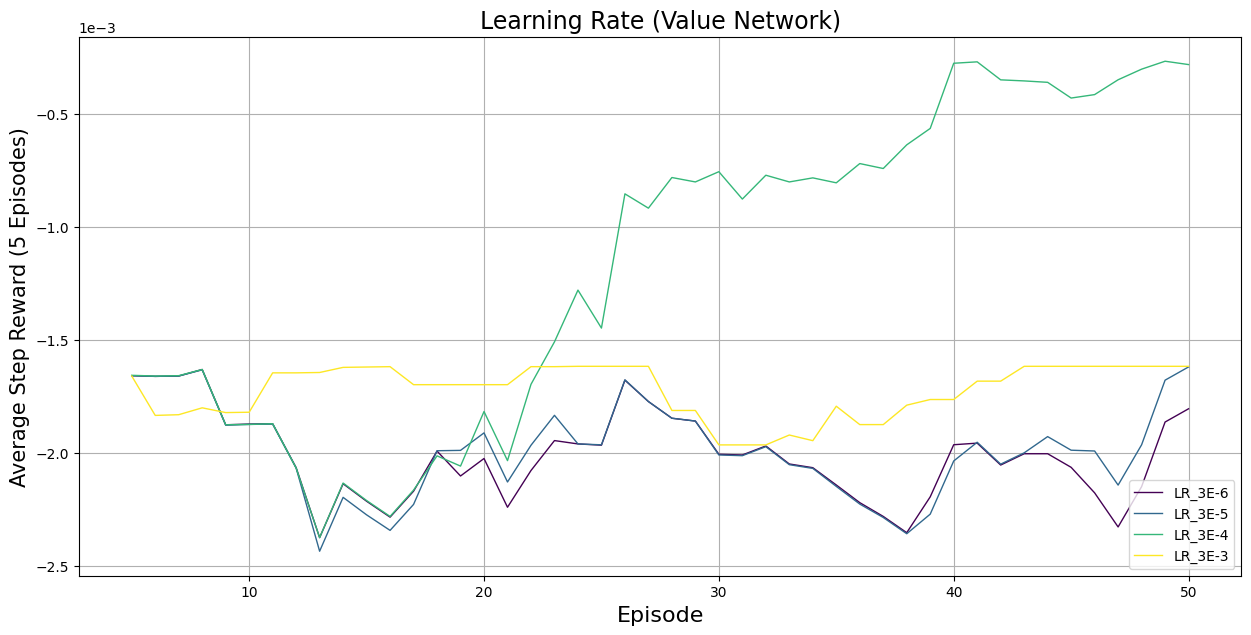

In [5]:

subfolders_to_search: dict = {'Learning_Rate_Policy': ['2023-11-16_09-23-48']}
name = 'Learning Rate (Policy Network)'
window = 5
generate_plot(subfolders_to_search,window,name)

subfolders_to_search: dict = {'Learning_Rate_Value': ['Combined']}
name = 'Learning Rate (Value Network)'
window = 5
generate_plot(subfolders_to_search,window,name)


### Beta
Note that policy network, beta=4 and beta=8 cases seem to have not learned anything. This is likely a bug, as beta=4 was used in the learning rate search without issue. 

These two cases were run on the same terminal, whereas beta=1,2,16 were run in parallel to save time. Rerun these cases when possible, but assume for now that 4 and 8 have similar performance to 2 and 16.

Conclusions: Beta doesn't have a significant impact on policy network training. Larger beta values are better for the value network, propose beta=8 going forwards.

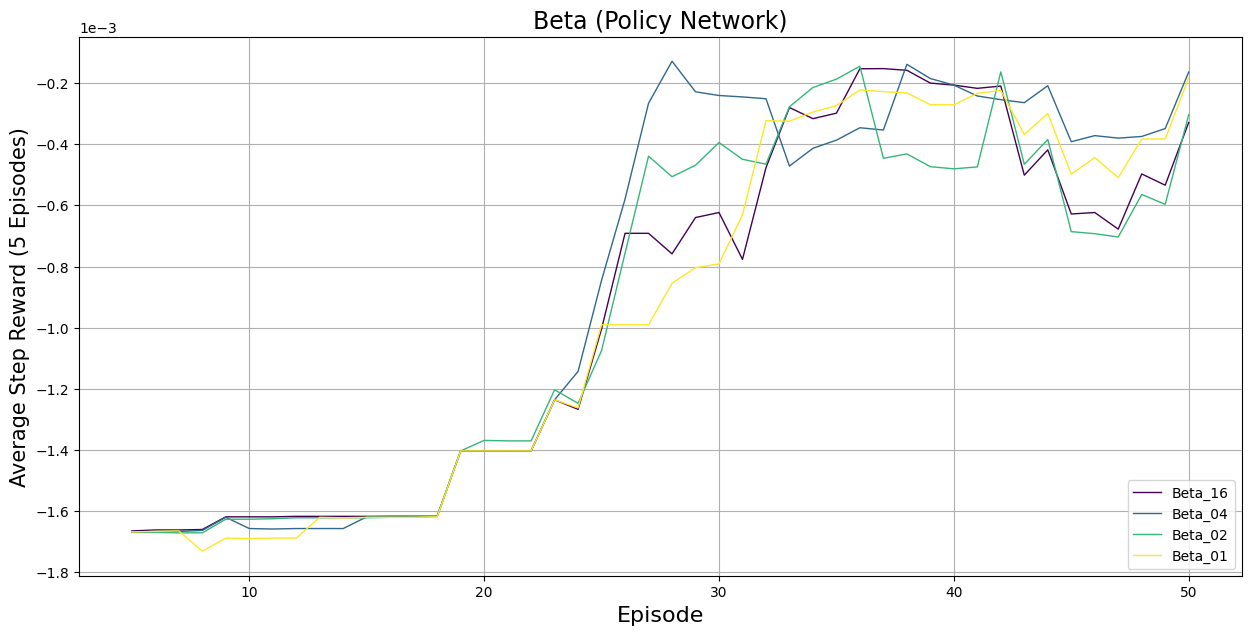

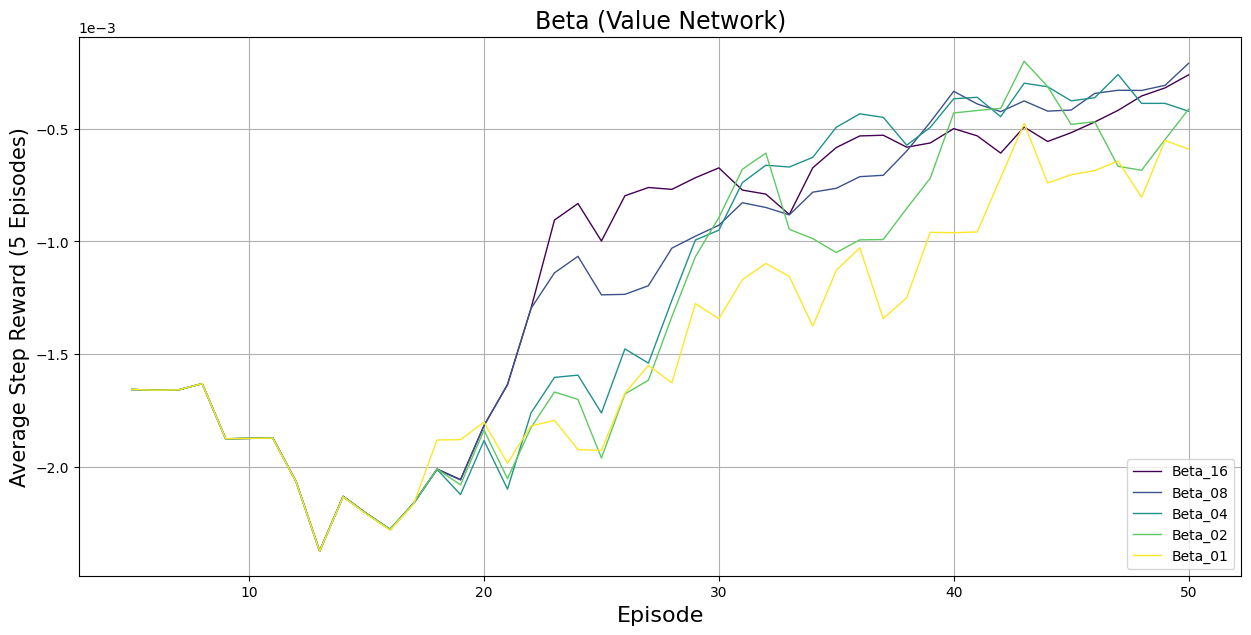

In [6]:

subfolders_to_search: dict = {'Beta_Policy': ['Combined']}
name = 'Beta (Policy Network)'
window = 5
generate_plot(subfolders_to_search,window,name)

subfolders_to_search: dict = {'Beta_Value': ['Combined']}
name = 'Beta (Value Network)'
window = 5
generate_plot(subfolders_to_search,window,name)


# Interim comparisons
Note that the DWave system went down for maintenance between episode 43+44 (training slowed down so much that it hadn't reached the next episode when the system came back online) when training the Value+Policy case. There may be some odd results near this point

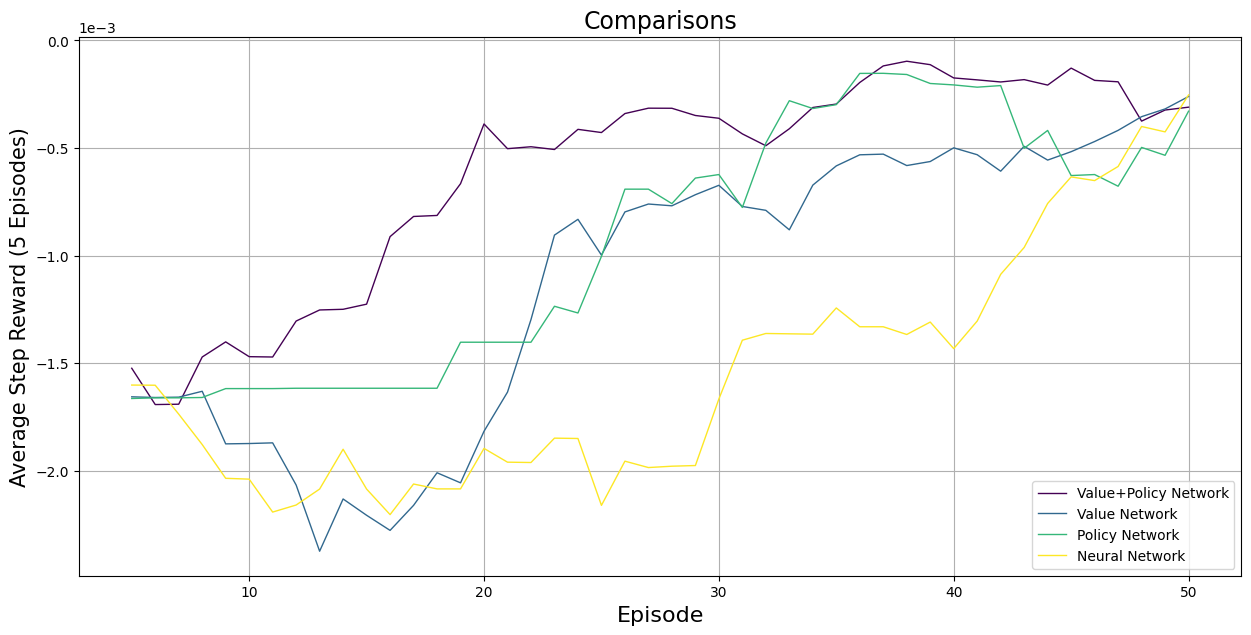

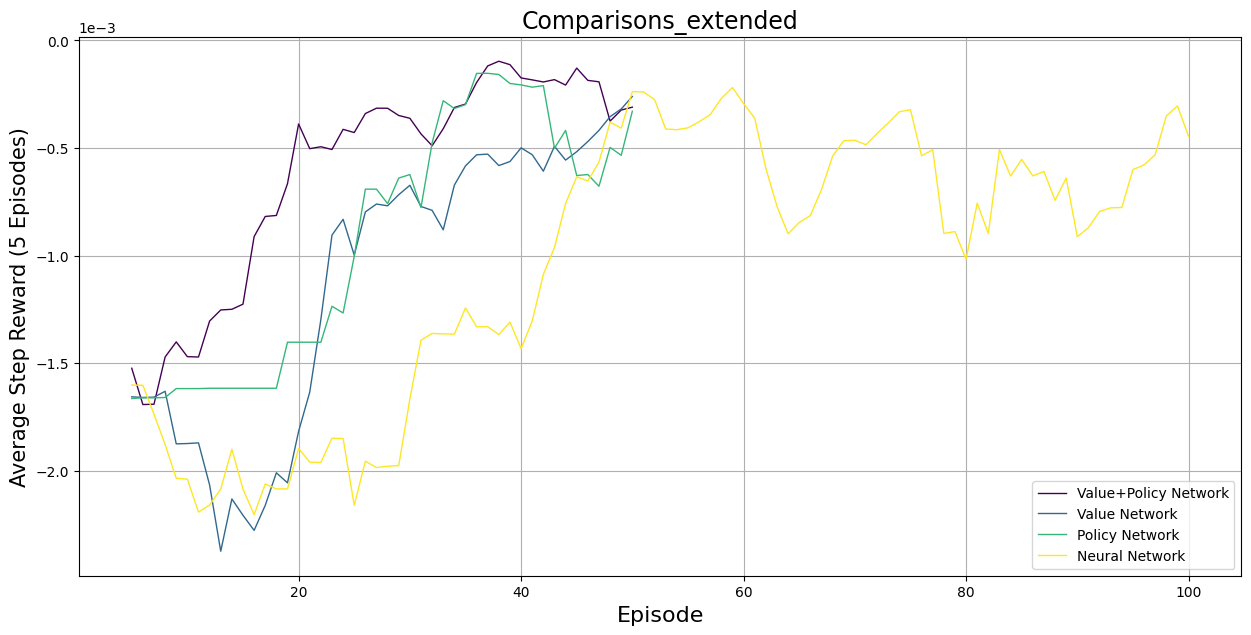

In [7]:
subfolders_to_search: dict = {'Comparisons': ['30_ACL_Optimised']}
name = 'Comparisons'
window = 5
generate_plot(subfolders_to_search,window,name)

subfolders_to_search: dict = {'Comparisons': ['30_ACL_Optimised_extended']}
name = 'Comparisons_extended'
window = 5
generate_plot(subfolders_to_search,window,name)

### Harder Red Agent

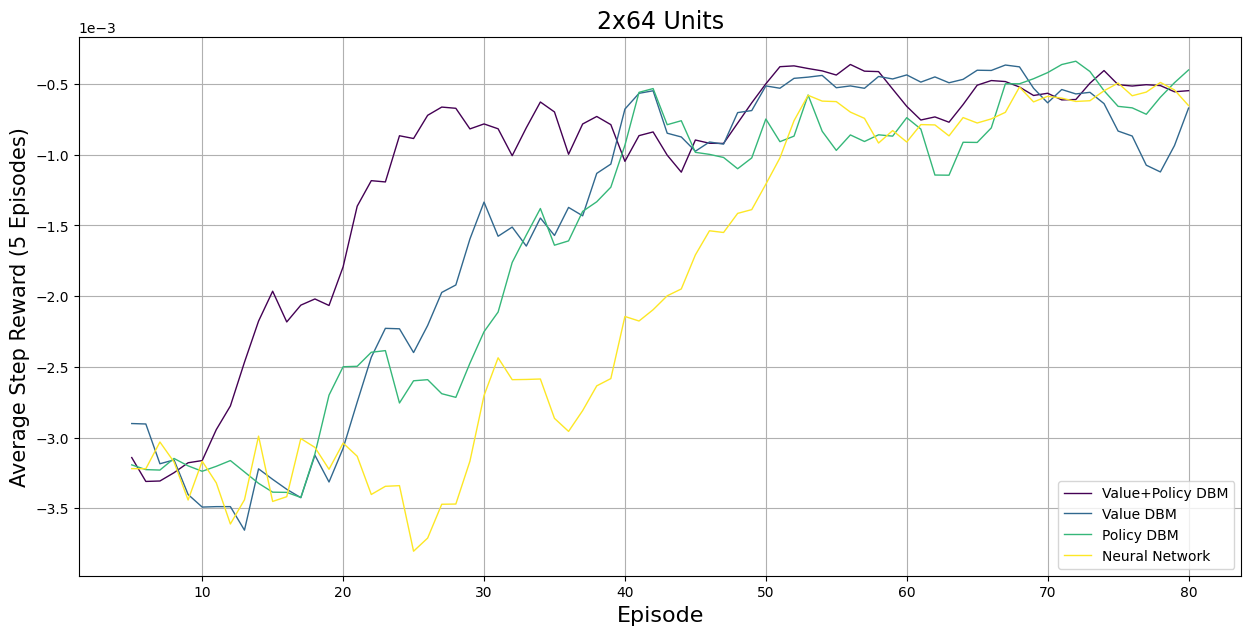

In [8]:
subfolders_to_search: dict = {'2x64_Optimised': ['allResults']}
name = '2x64 Units'
window = 5
generate_plot(subfolders_to_search,window,name)

### Deeper Networks

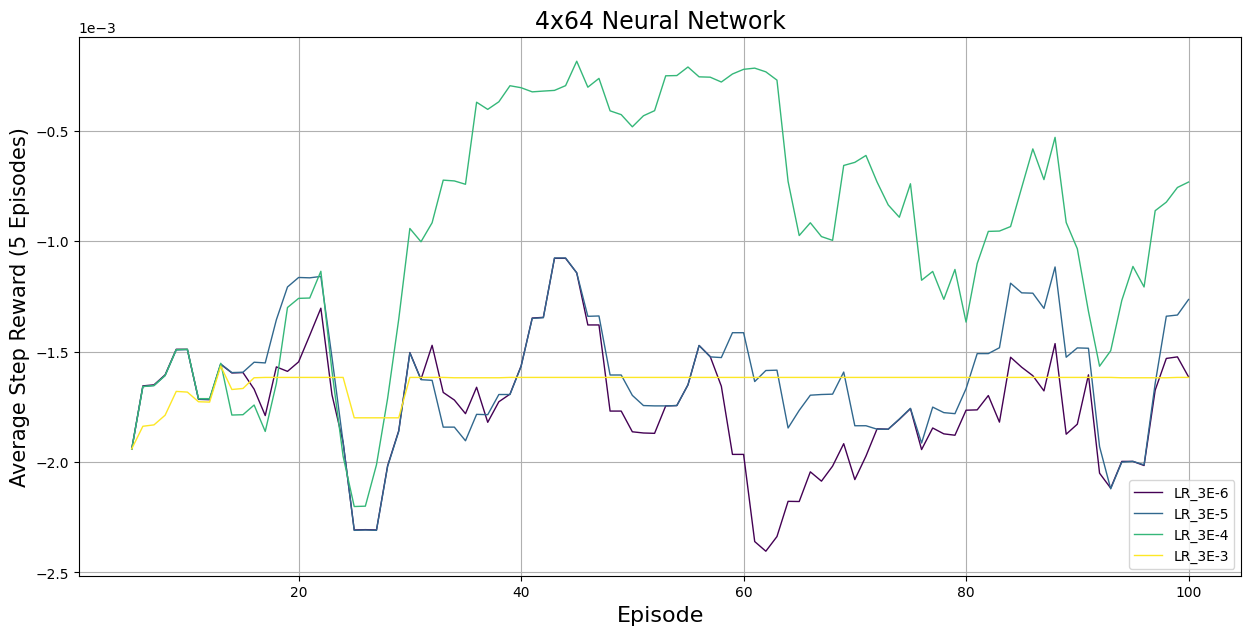

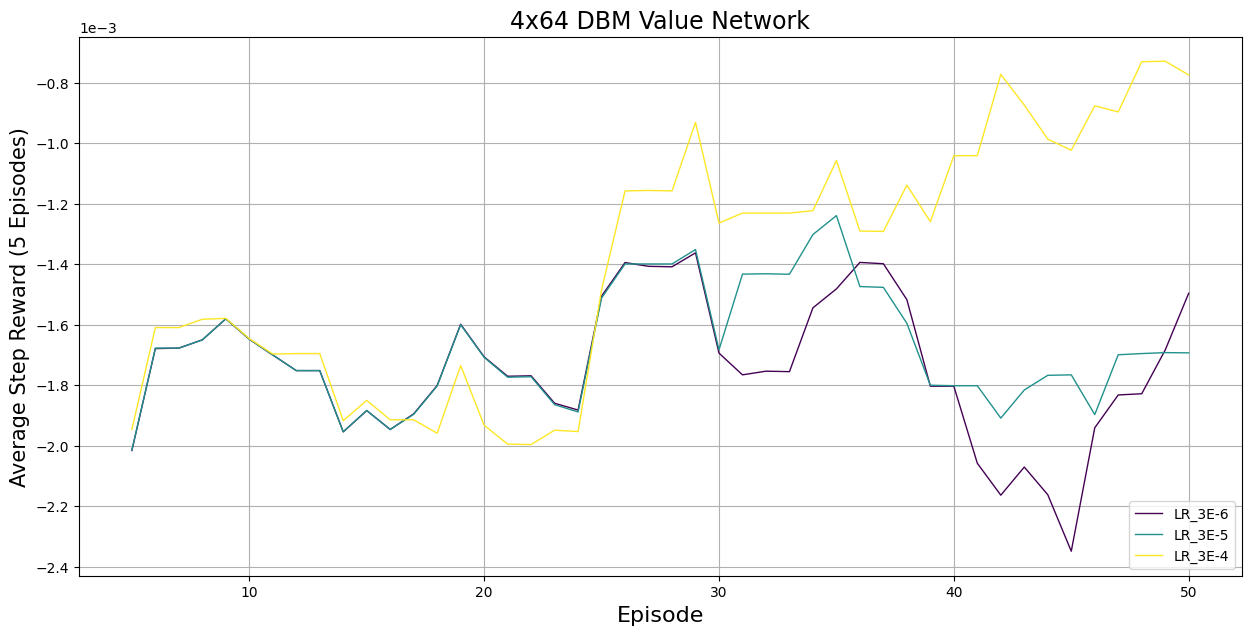

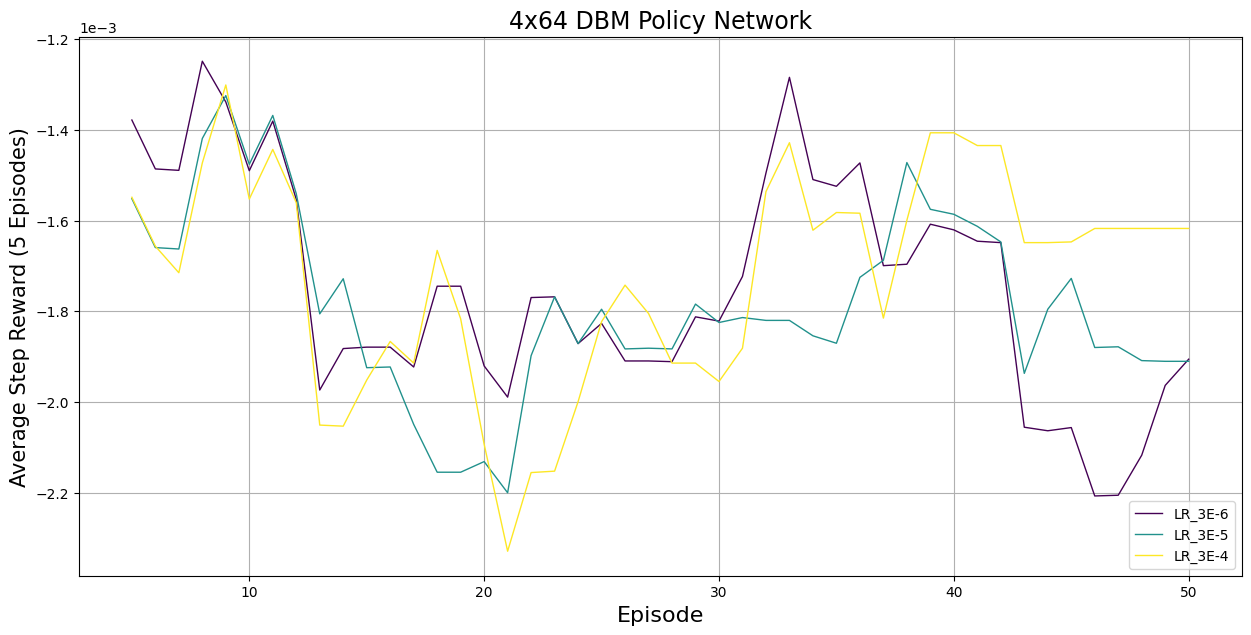

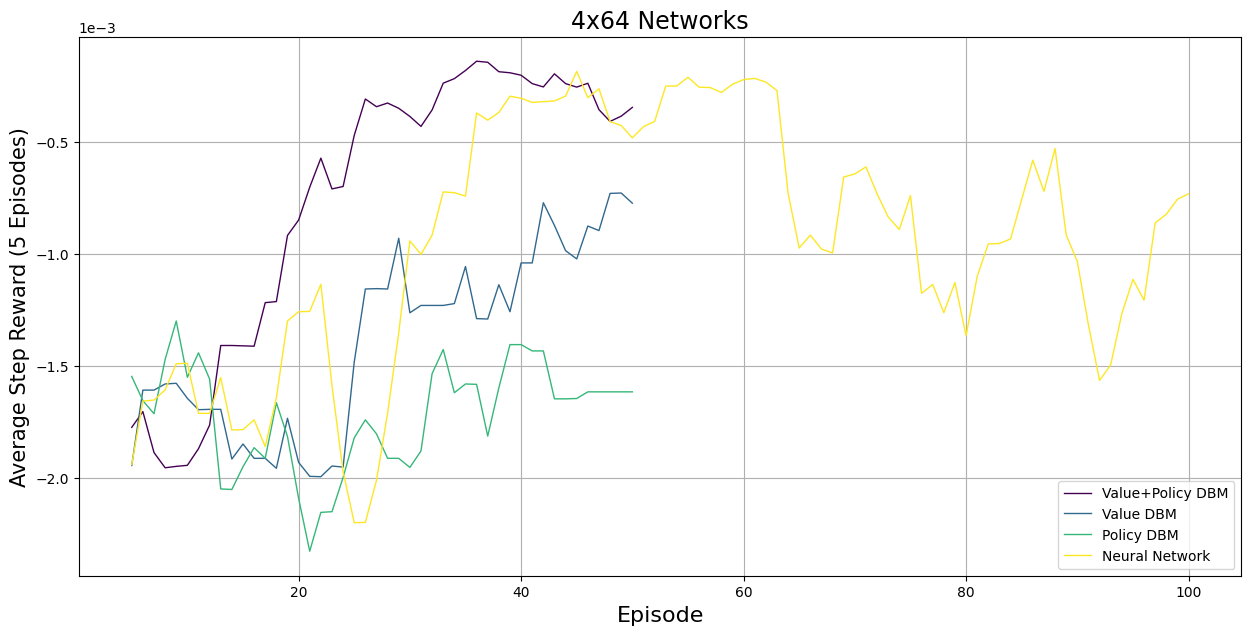

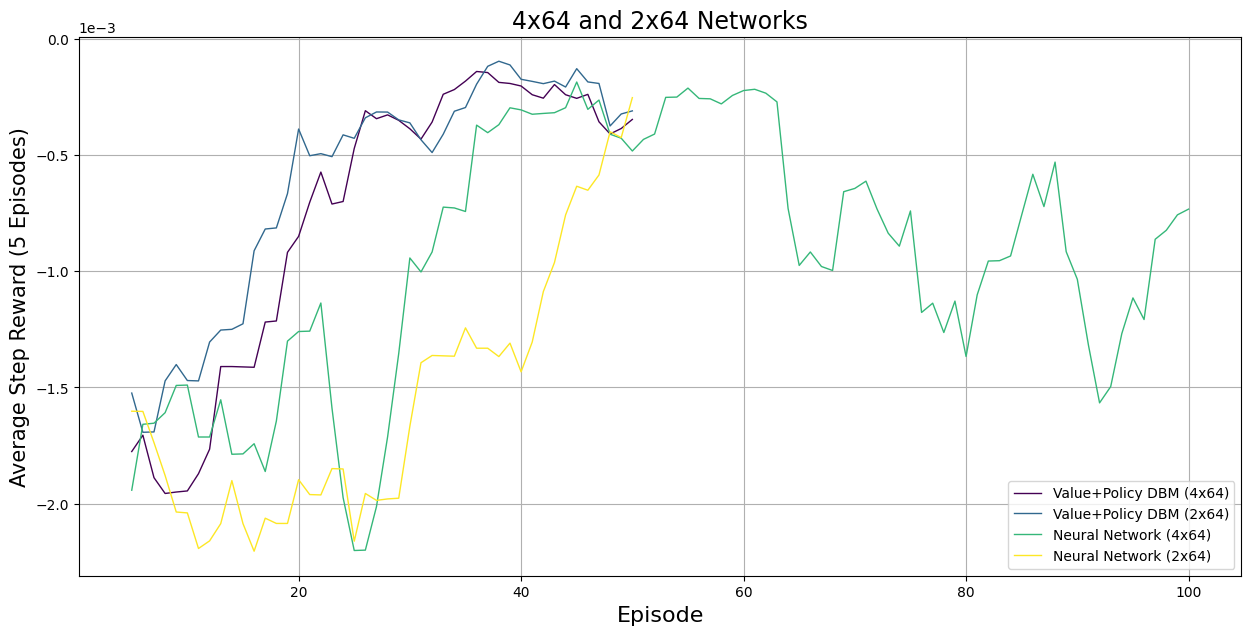

In [9]:
subfolders_to_search: dict = {'4x64_NN_LR': ['2023-12-06_10-48-05']}
name = '4x64 Neural Network'
window = 5
generate_plot(subfolders_to_search,window,name)

subfolders_to_search: dict = {'4x64_Value_LR': ['2023-12-06_11-23-56']}
name = '4x64 DBM Value Network'
generate_plot(subfolders_to_search,window,name)

subfolders_to_search: dict = {'4x64_Policy_LR': ['2023-12-06_11-49-11']}
name = '4x64 DBM Policy Network'
generate_plot(subfolders_to_search,window,name)

subfolders_to_search: dict = {'Comparisons': ['4x64']}
name = '4x64 Networks'
generate_plot(subfolders_to_search,window,name)

subfolders_to_search: dict = {'Comparisons': ['4x64 and 2x64']}
name = '4x64 and 2x64 Networks'
generate_plot(subfolders_to_search,window,name)



### Random Red Agent
Note that # ACL rules has been set to 1 to make the solution converge quickly

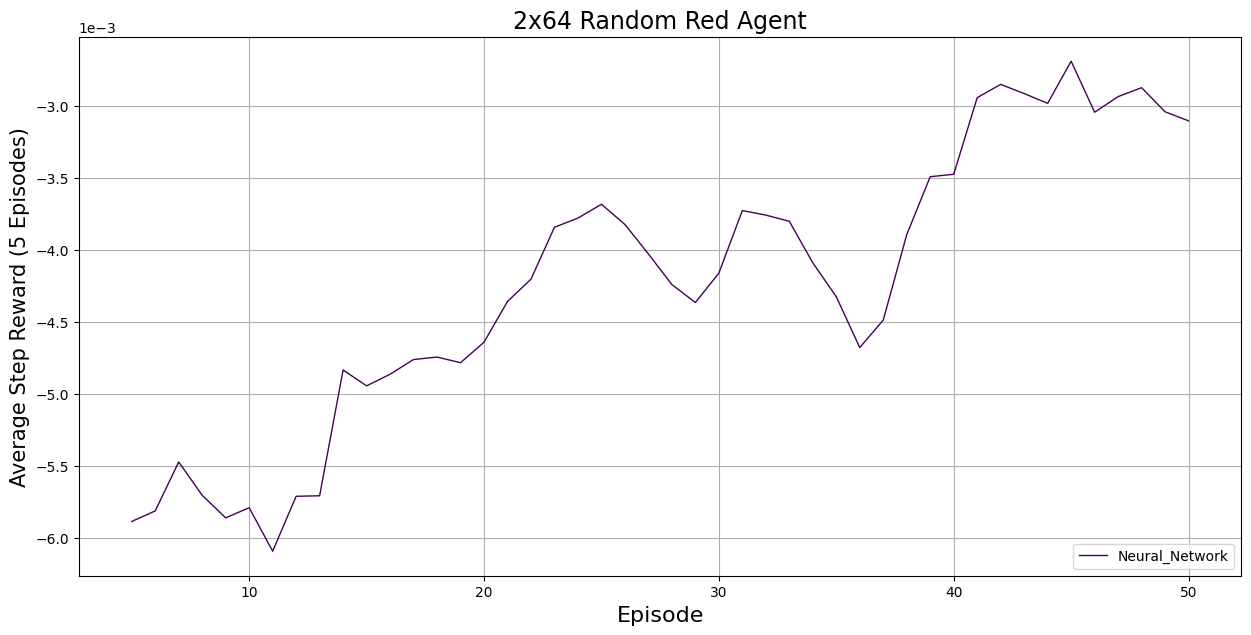

In [10]:
subfolders_to_search: dict = {'2x64_Random_Red_Agent': ['2023-12-12_14-55-02']}
name = '2x64 Random Red Agent'
window = 5
generate_plot(subfolders_to_search,window,name)


### Larger Networks

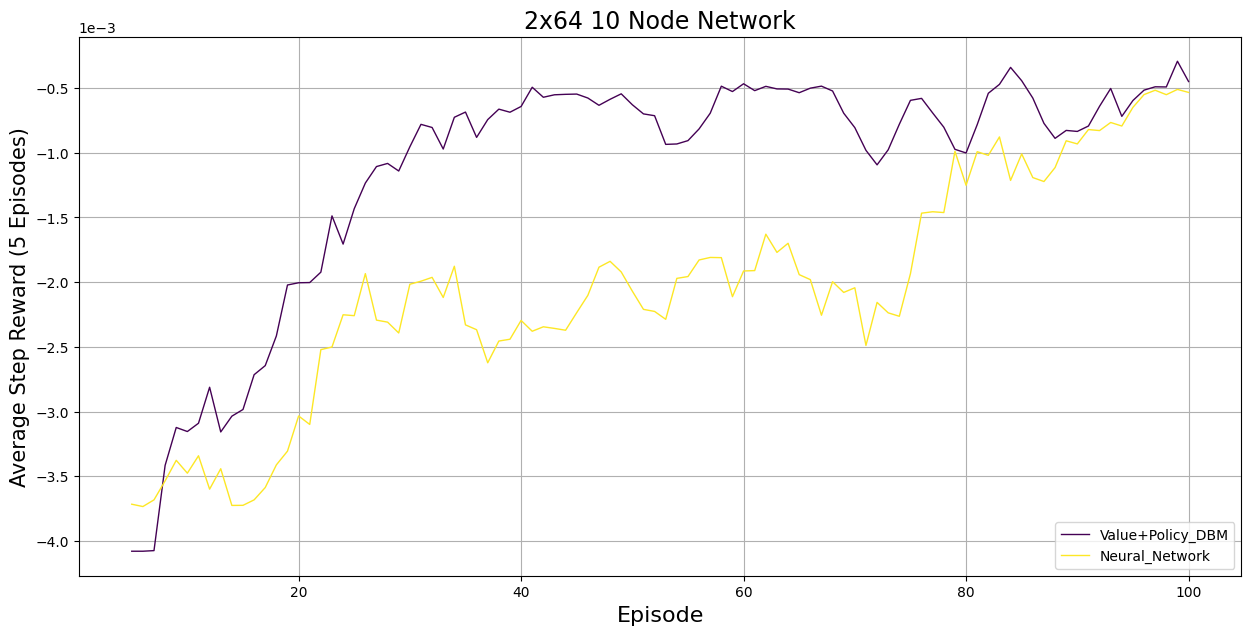

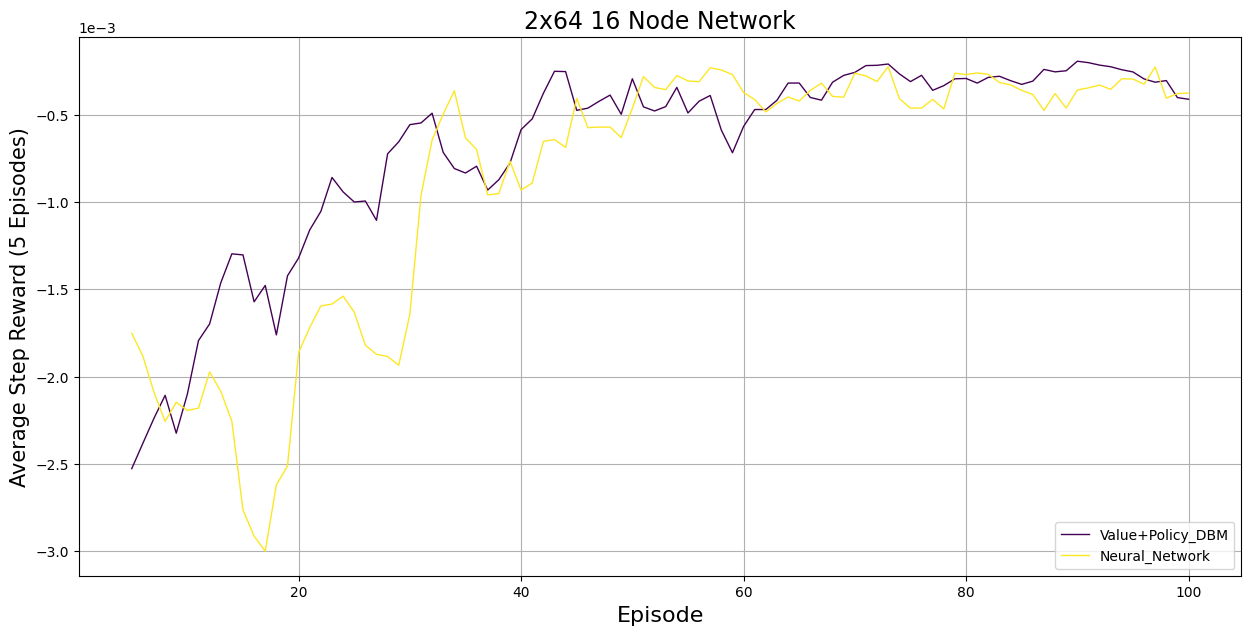

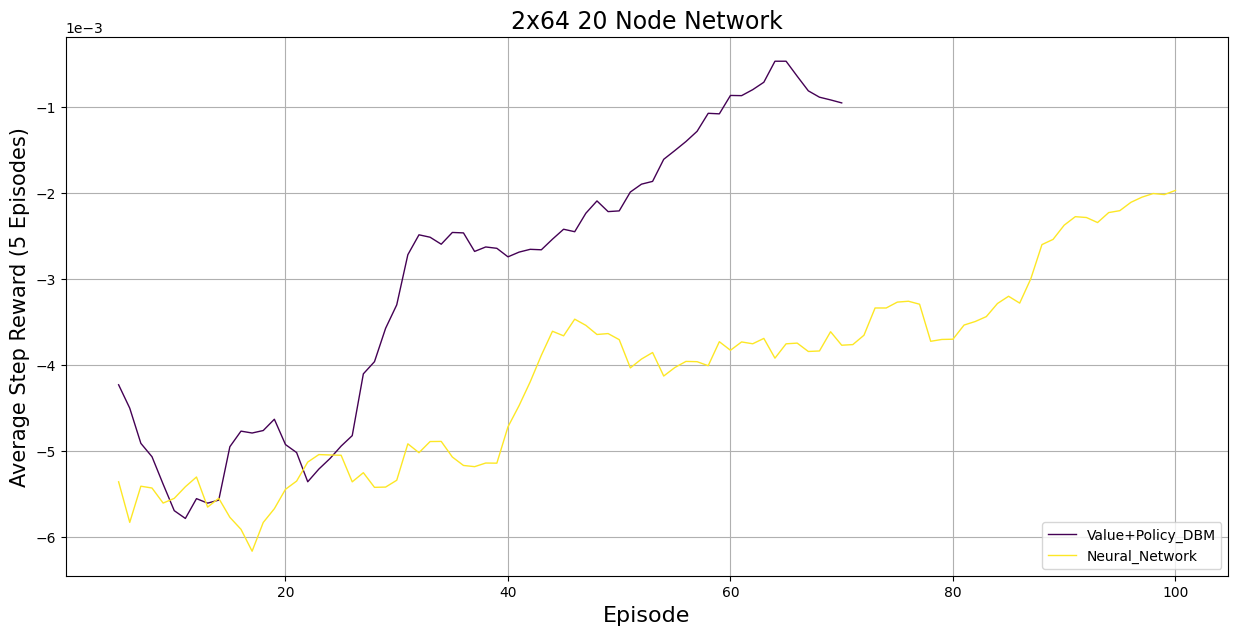

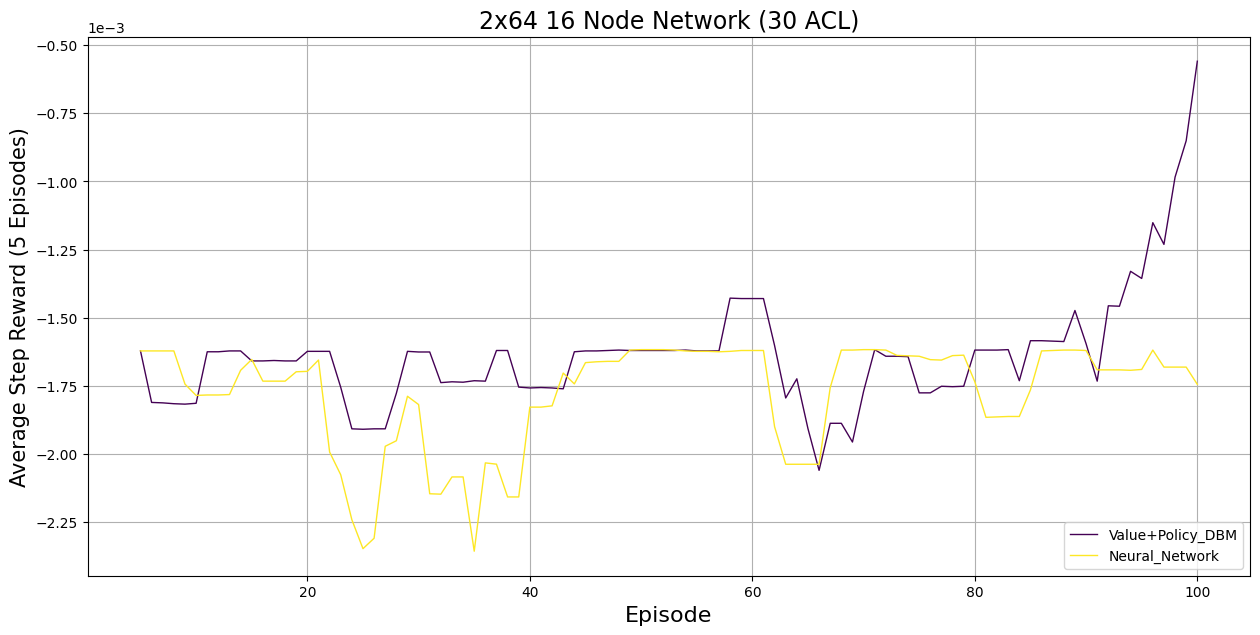

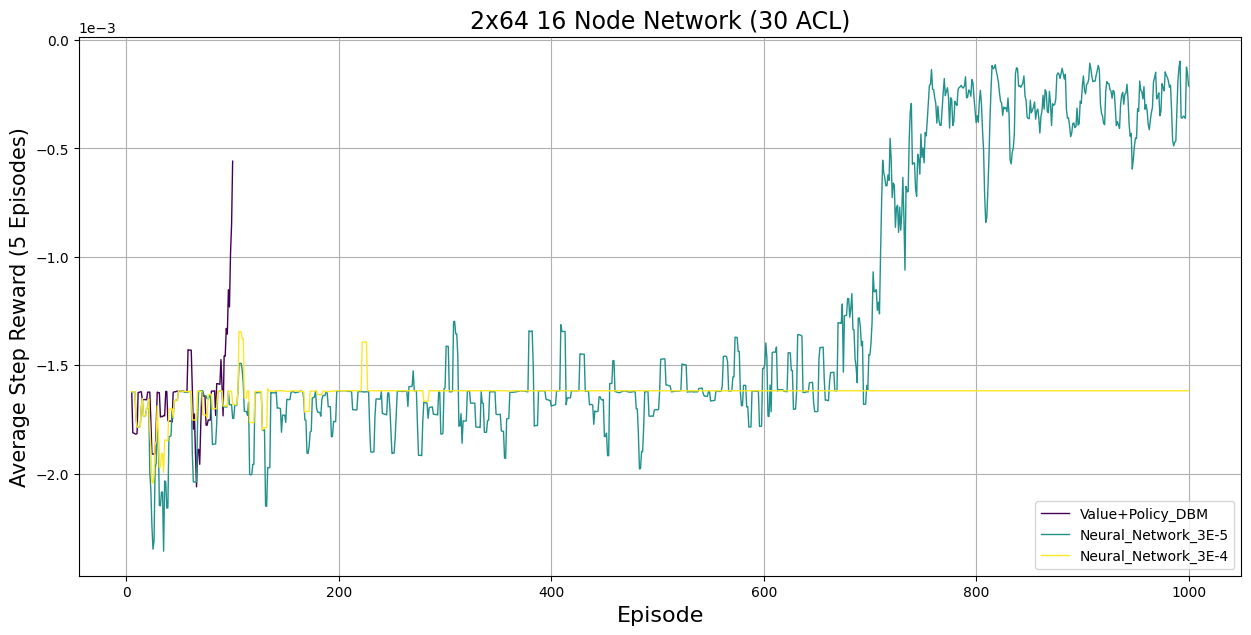

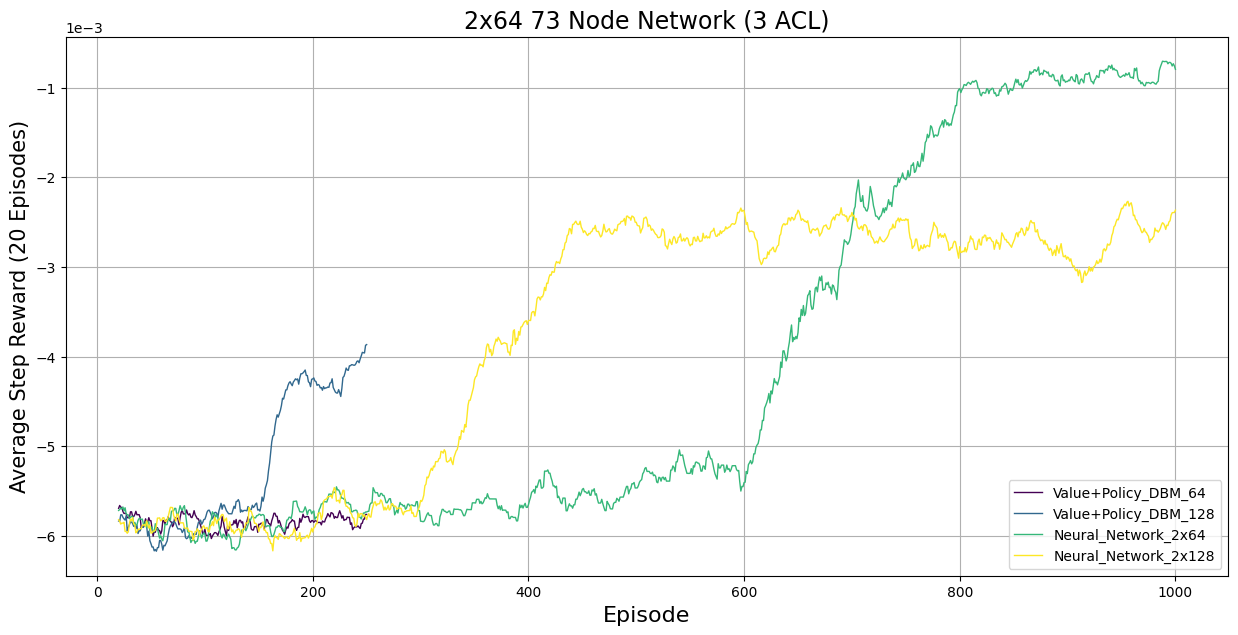

In [13]:
subfolders_to_search: dict = {'2x64_100_Episodes': ['2023-12-14_09-02-34']}
name = '2x64 10 Node Network'
window = 5
generate_plot(subfolders_to_search,window,name)

subfolders_to_search: dict = {'2x64_100_Episodes_5ACL': ['2023-12-21_15-58-37']}
name = '2x64 16 Node Network'
generate_plot(subfolders_to_search,window,name)

subfolders_to_search: dict = {'2x64_100_Episodes_5ACL': ['2023-12-25_02-51-09_manualDBM']}
name = '2x64 20 Node Network'
generate_plot(subfolders_to_search,window,name)

subfolders_to_search: dict = {'2x64_100_Episodes_lowMemory': ['2024-01-02_11-01-54']}
name = '2x64 16 Node Network (30 ACL)'
generate_plot(subfolders_to_search,window,name)

subfolders_to_search: dict = {'2x64_1000_Episodes': ['2024-01-08_08-17-14_with100DBM']}
name = '2x64 16 Node Network (30 ACL)'
generate_plot(subfolders_to_search,window,name)

subfolders_to_search: dict = {'2x64_RealisticRuns': ['Combined']}
name = '2x64 73 Node Network (3 ACL)'
generate_plot(subfolders_to_search,20,name)

